In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import datasets

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

import PIL.Image #saving images


## Importing the labeled faces dataset

In [2]:
dataset = datasets.fetch_lfw_people(download_if_missing=True)

images = dataset.images.astype('float32') / 255.
print(images.shape)
print(images[0].shape)
img_shape = images[0].shape;
pixels = img_shape[0] * img_shape[1]
print(pixels)

(13233, 62, 47)
(62, 47)
2914


## Visualizing images

In [3]:
def plotImages(original_imgs, rec_imgs = None, n = 10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
      # display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(original_imgs[i])
      plt.title("original")
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if(rec_imgs is not None):
      # display reconstruction
          ax = plt.subplot(2, n, i + 1 + n)
          plt.imshow(rec_imgs[i])
          plt.title("reconstructed")
          plt.gray()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
    plt.show()

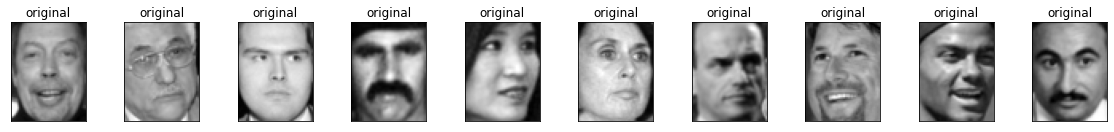

In [4]:
plotImages(dataset.images, n = 10)

## Training / Test split

In [5]:
x_train, x_test = train_test_split(
    images, test_size=0.2, random_state=12345, shuffle=True
)
print(x_train.shape)
print(x_test.shape)


(10586, 62, 47)
(2647, 62, 47)


## The basic autoencoder

In [6]:
latent_dim = 128 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(), # flatten image (62x47) to layer
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Input(shape = (latent_dim, )),
      layers.Dense(pixels, activation='sigmoid'),
      layers.Reshape(img_shape) # reverse flattening of image
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)


In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


In [8]:
cb_earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    restore_best_weights=True,
)


autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[cb_earlyStopping])

Epoch 1/50
662/662 [==============================] - 13s 7ms/step - loss: 0.0196 - val_loss: 0.0166
Epoch 2/50
662/662 [==============================] - 4s 7ms/step - loss: 0.0156 - val_loss: 0.0148
Epoch 3/50
662/662 [==============================] - 4s 7ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 4/50
662/662 [==============================] - 5s 7ms/step - loss: 0.0140 - val_loss: 0.0137
Epoch 5/50
662/662 [==============================] - 5s 7ms/step - loss: 0.0136 - val_loss: 0.0133
Epoch 6/50
662/662 [==============================] - 4s 7ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 7/50
662/662 [==============================] - 4s 7ms/step - loss: 0.0129 - val_loss: 0.0131
Epoch 8/50
662/662 [==============================] - 4s 6ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 9/50
662/662 [==============================] - 4s 6ms/step - loss: 0.0124 - val_loss: 0.0127
Epoch 10/50
662/662 [==============================] - 4s 6ms/step - loss: 0.0122 - val_loss: 0.012

In [9]:
autoencoder.encoder.summary()

autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2914)              0         
                                                                 
 dense (Dense)               (None, 128)               373120    
                                                                 
Total params: 373,120
Trainable params: 373,120
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2914)              375906    
                                                                 
 reshape (Reshape)           (None, 62, 47)            0         
                                                                 
Total params: 375,906
Traina

In [10]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

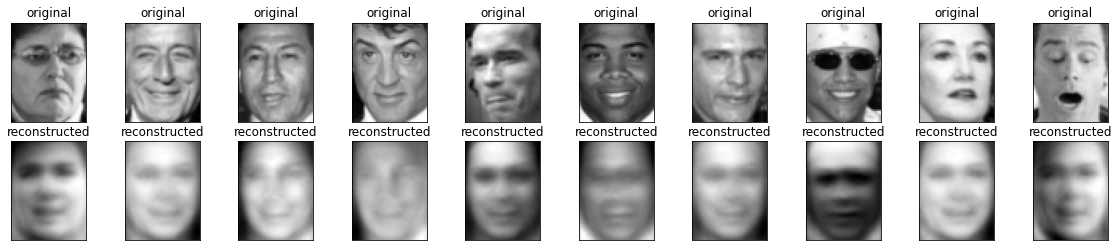

In [11]:
plotImages(x_test, decoded_imgs, n = 10)

## Generate an image

In [12]:
latent_code = np.arange(0.01, 0.01*(latent_dim+1), 0.01, dtype='float32')
latent_code_reshaped = latent_code[np.newaxis, ...] # reshape so that decoder doesn't complain
print(latent_code.shape)
print(latent_code_reshaped.shape)


(128,)
(1, 128)


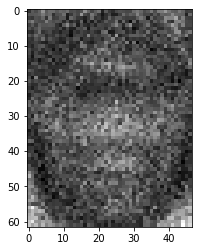

In [13]:
generated_imgs = autoencoder.decoder(latent_code_reshaped).numpy()
plt.imshow(generated_imgs[0])

In [29]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

file_name = './generated_img.jpg'
tensor_to_image(generated_imgs[0]).save(file_name)

### Feed generated image in encode-decode loop to see what happens 

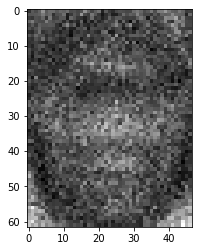

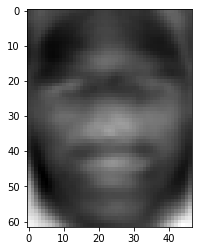

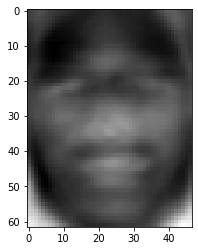

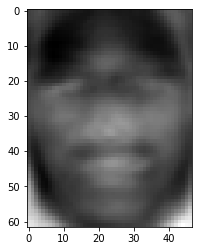

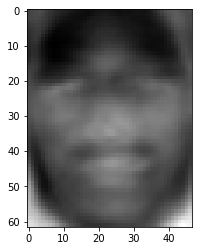

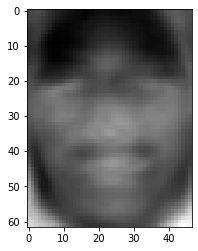

In [14]:
looped_imgs = generated_imgs
plt.figure()
plt.imshow(looped_imgs[0])
plt.show()
for x in range(5):
    looped_imgs = autoencoder.encoder(looped_imgs).numpy()
    looped_imgs = autoencoder.decoder(looped_imgs).numpy()
    plt.figure()
    plt.imshow(looped_imgs[0])
    plt.show()

## Denoiser

### Resize images to (64, 48) 

In [15]:

imgWithAxis = images[..., tf.newaxis] # reshape expects extra dim for channels
reshaped_imgs = tf.image.resize(
    imgWithAxis,
    [64, 48],
    method=tf.image.ResizeMethod.BILINEAR,
    preserve_aspect_ratio=False
)

#remove channels again
# reshaped_imgs=reshaped_imgs[:,:,:,0]
# and make it a numpy array
reshaped_imgs=reshaped_imgs.numpy()



In [16]:
x_train, x_test = train_test_split(
    reshaped_imgs, test_size=0.2, random_state=12345, shuffle=True
)
print(x_train.shape)
print(x_test.shape)


(10586, 64, 48, 1)
(2647, 64, 48, 1)


In [17]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)


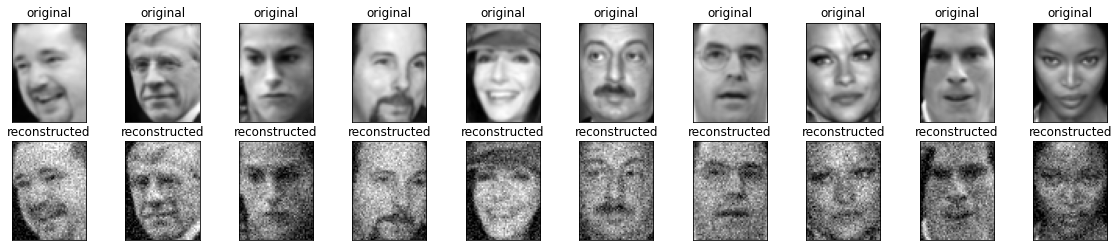

In [18]:
plotImages(x_train, x_train_noisy, 10)

## Denoiser

In [19]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(64, 48, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)
    ])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

denoiseAutoencoder = Denoise()

In [20]:
denoiseAutoencoder.compile(optimizer='adam', loss='mae')

In [21]:
cb_earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    restore_best_weights=True,
)

denoiseAutoencoder.fit(x_train_noisy, x_train,
                epochs=25,
                batch_size=16,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[cb_earlyStopping])

Epoch 1/25
662/662 [==============================] - 13s 10ms/step - loss: 0.0496 - val_loss: 0.0318
Epoch 2/25
662/662 [==============================] - 6s 10ms/step - loss: 0.0309 - val_loss: 0.0300
Epoch 3/25
662/662 [==============================] - 7s 10ms/step - loss: 0.0298 - val_loss: 0.0297
Epoch 4/25
662/662 [==============================] - 7s 11ms/step - loss: 0.0293 - val_loss: 0.0289
Epoch 5/25
662/662 [==============================] - 6s 9ms/step - loss: 0.0289 - val_loss: 0.0286
Epoch 6/25
662/662 [==============================] - 6s 10ms/step - loss: 0.0287 - val_loss: 0.0283
Epoch 7/25
662/662 [==============================] - 6s 9ms/step - loss: 0.0285 - val_loss: 0.0283
Epoch 8/25
662/662 [==============================] - 7s 10ms/step - loss: 0.0283 - val_loss: 0.0282
Epoch 9/25
662/662 [==============================] - 7s 10ms/step - loss: 0.0282 - val_loss: 0.0280
Epoch 10/25
662/662 [==============================] - 6s 9ms/step - loss: 0.0281 - val_loss

In [22]:
denoiseAutoencoder.encoder.summary()
denoiseAutoencoder.decoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 24, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 12, 8)         1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 32, 24, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 48, 16)       1168      
 ranspose)                    

In [23]:

encoded_imgs = denoiseAutoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = denoiseAutoencoder.decoder(encoded_imgs).numpy()

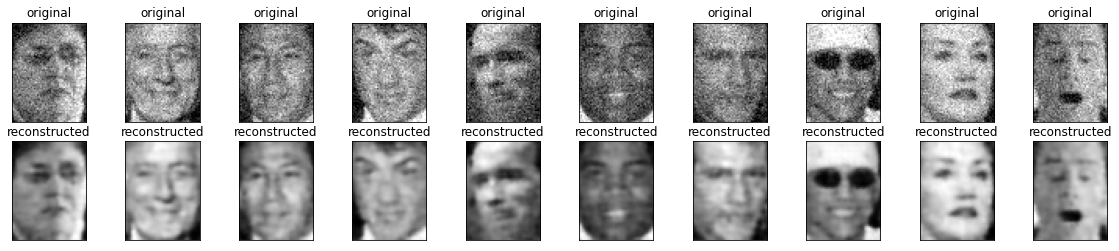

In [24]:
plotImages(x_test_noisy, decoded_imgs, n=10)